## **Model Tuning Notebook**

In [1]:
from numba import cuda
import tensorflow as tf

def clear_gpu_memory():
    device = cuda.get_current_device()
    device.reset() # dump the memory contents to free up the memory (it accumulates over the session)
    
# CUDA (Nvidia GPU Computing)
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    
    clear_gpu_memory()
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.set_logical_device_configuration(
    gpus[0], 
    [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # limit to 4GB

    tf.compat.v1.disable_eager_execution()


Num GPUs Available:  1


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

from src.utils.modeling import *
from src.utils.preproc import *

from keras.models import Model, Sequential, load_model
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

from sklearn.metrics import classification_report

In [3]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: d:\deep_learning_project CWD: d:\deep_learning_project


### **Binary Classification Models Fine-Tuning**

#### **Traditional**

#### **Pre-Trained**

**VGG 16**

In [4]:
def binary_classification_vgg16_model(input_shape):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-7]:
        layer.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    clear_gpu_memory()

train_gen, val_gen, test_gen, class_weights = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=6,
                                                    batch_size=64)

vgg16_binary = binary_classification_vgg16_model((224, 224, 3))

fitted_vgg16_binary = train_model(train_gen, val_gen, vgg16_binary, class_weights=class_weights, epochs=30, early_stopping_patience=8)

Epoch 1/30
606/606 [==============================] - ETA: 0s - batch: 302.5000 - size: 63.9125 - loss: 0.3881 - accuracy: 0.8250

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


606/606 [==============================] - 767s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.3881 - accuracy: 0.8250 - val_loss: 0.2230 - val_accuracy: 0.9106
Epoch 2/30
606/606 [==============================] - 649s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.2038 - accuracy: 0.9180 - val_loss: 0.1898 - val_accuracy: 0.9191
Epoch 3/30
606/606 [==============================] - 651s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.1453 - accuracy: 0.9421 - val_loss: 0.1615 - val_accuracy: 0.9309
Epoch 4/30
606/606 [==============================] - 652s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.1184 - accuracy: 0.9529 - val_loss: 0.1241 - val_accuracy: 0.9519
Epoch 5/30
606/606 [==============================] - 649s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.1027 - accuracy: 0.9617 - val_loss: 0.2154 - val_accuracy: 0.9250
Epoch 6/30
606/606 [==============================] - 648s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.0956 - accuracy

Loading test data...
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch



Accuracy: 0.9359

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.845794 | 0.973118 |   0.905    |       372 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.986807 | 0.918919 |   0.951654 |       814 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.935919 |
+------------------------+----------+
| Macro Avg Precision    | 0.916301 |
+------------------------+----------+
| Macro Avg Recall       | 0.946019 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.928327 |
+------------------------+----------+
| Weighted Avg Precision | 0.942577 |
+------------------------+----------

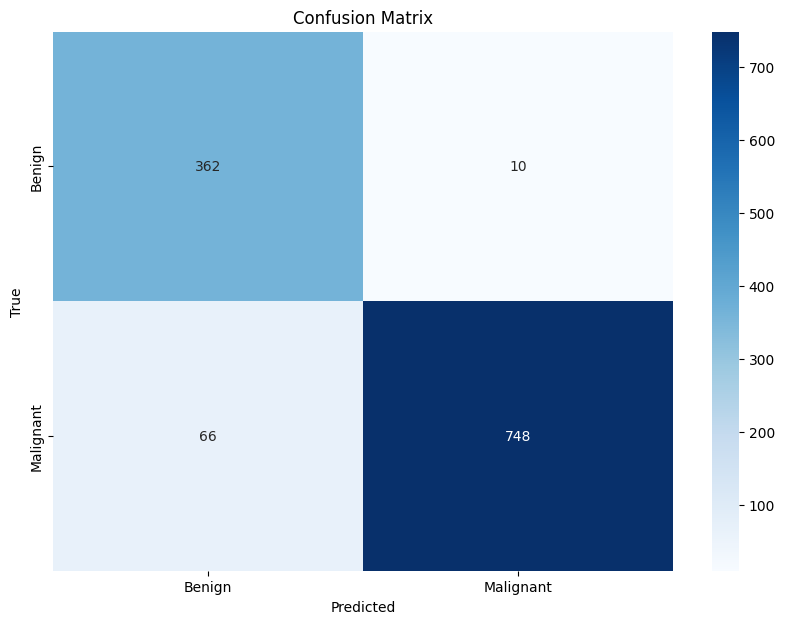

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.9359190556492412,
 'classification_report': {'Benign': {'precision': 0.8457943925233645,
   'recall': 0.9731182795698925,
   'f1-score': 0.905,
   'support': 372.0},
  'Malignant': {'precision': 0.9868073878627969,
   'recall': 0.918918918918919,
   'f1-score': 0.9516539440203562,
   'support': 814.0},
  'accuracy': 0.9359190556492412,
  'macro avg': {'precision': 0.9163008901930807,
   'recall': 0.9460185992444057,
   'f1-score': 0.9283269720101781,
   'support': 1186.0},
  'weighted avg': {'precision': 0.9425773421070895,
   'recall': 0.9359190556492412,
   'f1-score': 0.9370204978352191,
   'support': 1186.0}},
 'confusion_matrix': array([[362,  10],
        [ 66, 748]], dtype=int64)}

In [9]:
evaluate_model(fitted_vgg16_binary, classification_type='binary')

In [7]:
save_model(fitted_vgg16_binary, 'src/models/vgg16_binary_classification.h5')

<i> Data augmentation clearly improves the model's performance. </i>

### **Multiclass Classification Models Fine-Tuning**

#### **Traditional**

#### **Pre-Trained**

**VGG 16**

In [4]:
def multiclass_classification_vgg16_model(input_shape):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-7]:
        layer.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=2)
                                                    
vgg16_multiclass = multiclass_classification_vgg16_model((224, 224, 3))

fitted_vgg16 = train_model(train_gen, val_gen, vgg16_multiclass, steps_per_epoch=steps_per_epoch, class_weights=class_weights, epochs=30, early_stopping_patience=8)

Loading and preprocessing data...
Total training images after augmentation: 16599
Class weights computed.
Data generators created.
Epoch 1/30
344/344 [==============================] - ETA: 0s - batch: 171.5000 - size: 31.9826 - loss: 2.0652 - accuracy: 0.1226

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


344/344 [==============================] - 245s 607ms/step - batch: 171.5000 - size: 31.9826 - loss: 2.0652 - accuracy: 0.1226 - val_loss: 2.0125 - val_accuracy: 0.1046
Epoch 2/30
344/344 [==============================] - 190s 550ms/step - batch: 171.5000 - size: 31.9826 - loss: 1.7994 - accuracy: 0.2808 - val_loss: 1.4367 - val_accuracy: 0.5118
Epoch 3/30
344/344 [==============================] - 187s 542ms/step - batch: 171.5000 - size: 31.9913 - loss: 1.4330 - accuracy: 0.4207 - val_loss: 1.8753 - val_accuracy: 0.3162
Epoch 4/30
344/344 [==============================] - 253s 736ms/step - batch: 171.5000 - size: 31.9738 - loss: 1.1382 - accuracy: 0.5143 - val_loss: 1.2483 - val_accuracy: 0.5059
Epoch 5/30
344/344 [==============================] - 273s 793ms/step - batch: 171.5000 - size: 31.9826 - loss: 0.9684 - accuracy: 0.5524 - val_loss: 1.3087 - val_accuracy: 0.5051
Epoch 6/30
344/344 [==============================] - 273s 794ms/step - batch: 171.5000 - size: 31.9826 - loss:

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:82: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.8153

Classification Report:
+---------------------+-------------+----------+------------+-----------+
| Class               |   Precision |   Recall |   F1-Score |   Support |
+=====================+=============+==========+============+===========+
| Adenosis            |    0.913043 | 0.940299 |   0.926471 |        67 |
+---------------------+-------------+----------+------------+-----------+
| Ductal Carcinoma    |    0.951157 | 0.714286 |   0.815877 |       518 |
+---------------------+-------------+----------+------------+-----------+
| Fibroadenoma        |    0.938356 | 0.901316 |   0.919463 |       152 |
+---------------------+-------------+----------+------------+-----------+
| Lobular Carcinoma   |    0.615385 | 0.851064 |   0.714286 |        94 |
+---------------------+-------------+----------+------------+-----------+
| Mucinous Carcinoma  |    0.77037  | 0.881356 |   0.822134 |       118 |
+---------------------+-------------+----------+------------+---------

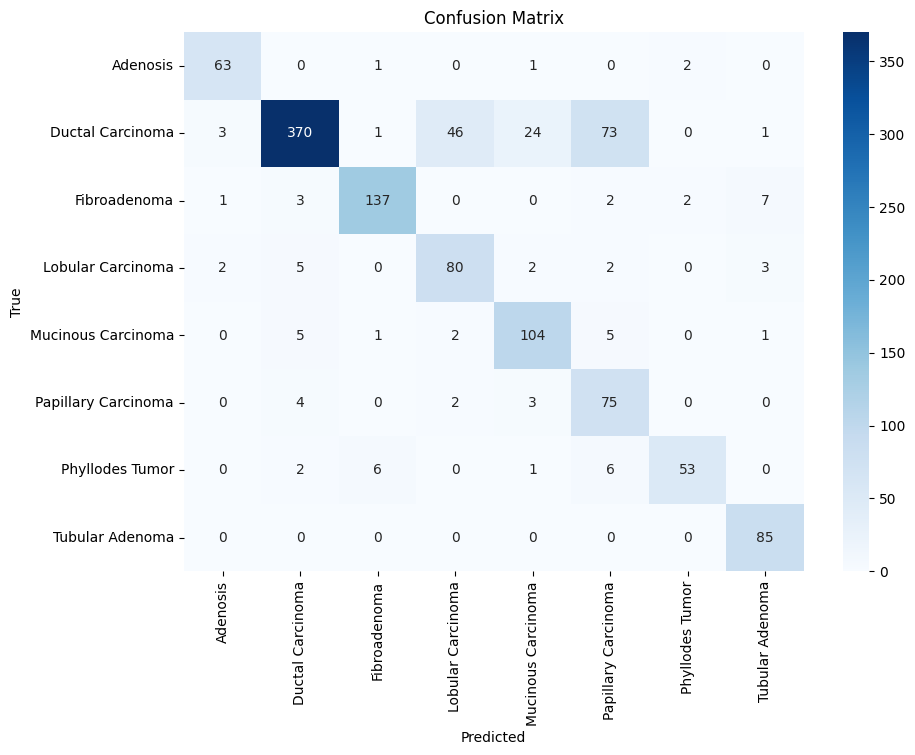

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.815345699831366,
 'classification_report': {'Adenosis': {'precision': 0.9130434782608695,
   'recall': 0.9402985074626866,
   'f1-score': 0.9264705882352942,
   'support': 67.0},
  'Ductal Carcinoma': {'precision': 0.9511568123393316,
   'recall': 0.7142857142857143,
   'f1-score': 0.8158765159867696,
   'support': 518.0},
  'Fibroadenoma': {'precision': 0.9383561643835616,
   'recall': 0.9013157894736842,
   'f1-score': 0.9194630872483222,
   'support': 152.0},
  'Lobular Carcinoma': {'precision': 0.6153846153846154,
   'recall': 0.851063829787234,
   'f1-score': 0.7142857142857143,
   'support': 94.0},
  'Mucinous Carcinoma': {'precision': 0.7703703703703704,
   'recall': 0.8813559322033898,
   'f1-score': 0.8221343873517787,
   'support': 118.0},
  'Papillary Carcinoma': {'precision': 0.4601226993865031,
   'recall': 0.8928571428571429,
   'f1-score': 0.6072874493927125,
   'support': 84.0},
  'Phyllodes Tumor': {'precision': 0.9298245614035088,
   'recall': 0.7794117

In [7]:
evaluate_model(fitted_vgg16, classification_type='multiclass')

In [8]:
save_model(fitted_vgg16, 'src/models/vgg16_multiclass_classification.h5')